In [1]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes


import json
import torch
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from huggingface_hub import HfFolder, notebook_login

! pip install transformers[torch] -U
! pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Succes

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
test_jsonl_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_chatGPT_test.jsonl"

In [9]:
# Function to load a dataset from a JSONL file
def load_jsonl_to_dataset(jsonl_path):
    data = []
    with open(jsonl_path, 'r') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue  # Skip lines that are not valid JSON
    return data

# Load datasets
test_data = load_jsonl_to_dataset(test_jsonl_path)



In [35]:
def prepare_dataset(data, abstract = "human_text", machine_abstract = "machine_text"):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})

    return dataset

In [12]:
from datasets import Dataset

# Prepare datasets
test_dataset = prepare_dataset(test_data)


In [13]:
print("Size of the dataset:", len(test_dataset))


Size of the dataset: 1200


In [14]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline, pipeline

tokenizer = AutoTokenizer.from_pretrained("andreas122001/roberta-academic-detector", model_max_length = 512)
model = AutoModelForSequenceClassification.from_pretrained("andreas122001/roberta-academic-detector")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/885 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [15]:
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=1,
    truncation=True,  # Ensures that input sequences are truncated
    padding=True      # Pads sequences to the maximum length
)


In [16]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

# Define classification function
def classify_text(example):
    try:
        predictions = classifier(example['text'])
        return {'predicted_labels': predictions[0][0]['label']}
    except Exception as e:
        print(f"Error processing example: {example['text']}")
        print(e)
        return {'predicted_labels': None}

# Apply the classification to all texts in the dataset and add the predicted_labels column
test_dataset = test_dataset.map(classify_text, batched=False)

# Check the first few entries to verify
print(test_dataset[0])
print(test_dataset[1])


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [17]:
print(test_dataset)


Dataset({
    features: ['text', 'labels', 'predicted_labels'],
    num_rows: 1200
})


In [18]:
df_test_dataset = test_dataset.to_pandas()
df_test_dataset['target_labels'] = df_test_dataset['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [19]:
df_test_dataset.head(5)


text  labels  \
0    We address the problem of constructing high-...       0   
1  In this work, we present a novel approach to t...       1   
2    We propose a pairing-based method for coolin...       0   
3  We present our work on pairing based cooling o...       1   
4    Energetic feedback processes during the form...       0   

    predicted_labels      target_labels  
0     human-produced     human-produced  
1  machine-generated  machine-generated  
2     human-produced     human-produced  
3  machine-generated  machine-generated  
4     human-produced     human-produced

In [20]:
predicted_labels = df_test_dataset.predicted_labels.to_list()
true_labels = df_test_dataset.target_labels.to_list()


Confusion Matrix:
[[600   0]
 [ 17 583]]


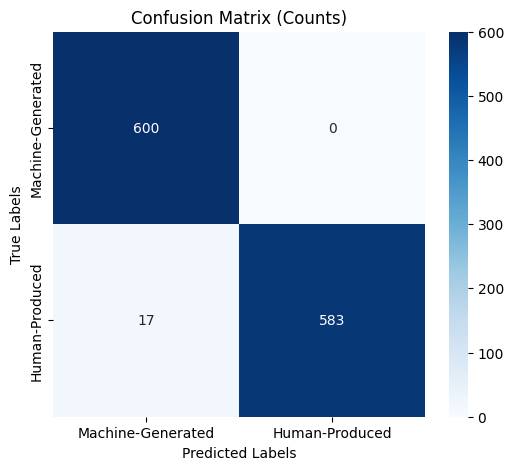

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')


In [27]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.9858
Precision: 0.9724
Recall: 1.0000


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [29]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"



##Testing Bloomz Dataset

In [37]:
bloomz_test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_bloomz_test.jsonl"
# Load datasets
bloomz_test_data = load_jsonl_to_dataset(bloomz_test_data_path)

print(bloomz_test_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
# Prepare datasets
bloomz_test_data = prepare_dataset(bloomz_test_data, abstract = "abstract", machine_abstract = "machine_abstract")
print("Size of the dataset:", len(bloomz_test_data))



Size of the dataset: 1200


In [39]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
bloomz_test_data = bloomz_test_data.map(classify_text, batched=False)
# Check the first few entries to verify
print(test_dataset[0])
print(test_dataset[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [46]:
df_test_dataset_bloomz = bloomz_test_data.to_pandas()
df_test_dataset_bloomz['target_labels'] = df_test_dataset_bloomz['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')
df_test_dataset_bloomz.head(5)




text  labels predicted_labels  \
0    We address the problem of constructing high-...       0   human-produced   
1  We present the first results for effective-one...       1   human-produced   
2    We propose a pairing-based method for coolin...       0   human-produced   
3  We propose to cool fermionic atoms in optical ...       1   human-produced   
4    Energetic feedback processes during the form...       0   human-produced   

       target_labels  
0     human-produced  
1  machine-generated  
2     human-produced  
3  machine-generated  
4     human-produced

In [48]:
predicted_labels = df_test_dataset_bloomz.predicted_labels.to_list()
true_labels = df_test_dataset_bloomz.target_labels.to_list()


Confusion Matrix:
[[108 492]
 [ 17 583]]


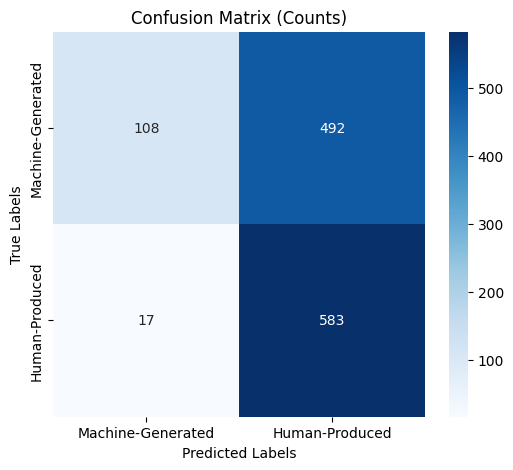

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')


In [50]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.5758
Precision: 0.8640
Recall: 0.1800


##Testing Coher data

In [51]:
coher_test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_cohere_test.jsonl"
coher_test_data = load_jsonl_to_dataset(coher_test_data_path)

print(coher_test_data)

[{'prompt': 'Generate an abstract for work with title: Faithful Effective-One-Body waveforms of small-mass-ratio coalescing   black-hole binaries. Describe the motivation for the research, the key ideas and methodology, the results obtained, problem work attempts to solve and any practical or theoretical applications from your findings or implications for future research in a formal academic and scientific writing voice. Use the first plural person form. Use active voice.', 'source_id': 705.2519, 'human_text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based wavefo

In [52]:
# Prepare datasets
coher_test_data = prepare_dataset(coher_test_data)
print("Size of the dataset:", len(bloomz_test_data))


Size of the dataset: 1200


In [53]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
coher_test_data = coher_test_data.map(classify_text, batched=False)
# Check the first few entries to verify
print(coher_test_data[0])
print(coher_test_data[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [54]:
df_test_dataset_coher = coher_test_data.to_pandas()
df_test_dataset_coher['target_labels'] = df_test_dataset_coher['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')
df_test_dataset_coher.head(5)



text  labels  \
0    We address the problem of constructing high-...       0   
1   We study the effects of small-mass-ratio on t...       1   
2    We propose a pairing-based method for coolin...       0   
3    We consider a recently proposed method to co...       1   
4    Energetic feedback processes during the form...       0   

    predicted_labels      target_labels  
0     human-produced     human-produced  
1     human-produced  machine-generated  
2     human-produced     human-produced  
3  machine-generated  machine-generated  
4     human-produced     human-produced

In [55]:
predicted_labels = df_test_dataset_coher.predicted_labels.to_list()
true_labels = df_test_dataset_coher.target_labels.to_list()


In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')


Confusion Matrix:
[[280 320]
 [ 17 583]]


In [57]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.7192
Precision: 0.9428
Recall: 0.4667


##Testing Davinci Data

In [58]:
davinci_test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_davinci_test.jsonl"
davinci_test_data = load_jsonl_to_dataset(davinci_test_data_path)

print(davinci_test_data)

[{'prompt': "Rephrase the abstract of an article with title 'Physical and Spectral Characteristics of the T8 and Later-Type Dwarfs'.   We use new and published near-IR spectra, with synthetic spectra, to derive physical properties of three of the latest-type T dwarfs. A new R~1700 spectrum of the T7.5 dwarf HD 3651B, with existing data, allows a detailed comparison to the well-studied and very similar dwarf, Gl 570D. We find that HD 3651B has both higher gravity and metallicity than Gl 570D, with Teff=820-830K, log g= 5.4-5.5, [m/H]= +0.2 and Kzz=10^4cm^2/s. Its age is 8-12 Gyr and its implied mass is 60-70 M_Jup. We perform a similar analyis of the T8 and T7.5 dwarfs 2MASS J09393548-2448279 and 2MASS J11145133-2618235 using published data, comparing them to the well-studied T8, 2MASS J04151954-0935066. We find that the two dwarfs have the same Teff as the reference dwarf, and similar gravities, but lower metallicities. The parameters are Teff=725-775K and [m/H]= -0.3; log g=5.3-5.45 f

In [59]:
# Prepare datasets
davinci_test_data = prepare_dataset(davinci_test_data)
print("Size of the dataset:", len(davinci_test_data))


Size of the dataset: 1200


In [60]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
davinci_test_data = davinci_test_data.map(classify_text, batched=False)
# Check the first few entries to verify
print(davinci_test_data[0])
print(davinci_test_data[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': '  We use new and published near-IR spectra, with synthetic spectra, to derive physical properties of three of the latest-type T dwarfs. A new R~1700 spectrum of the T7.5 dwarf HD 3651B, with existing data, allows a detailed comparison to the well-studied and very similar dwarf, Gl 570D. We find that HD 3651B has both higher gravity and metallicity than Gl 570D, with Teff=820-830K, log g= 5.4-5.5, [m/H]= +0.2 and Kzz=10^4cm^2/s. Its age is 8-12 Gyr and its implied mass is 60-70 M_Jup. We perform a similar analyis of the T8 and T7.5 dwarfs 2MASS J09393548-2448279 and 2MASS J11145133-2618235 using published data, comparing them to the well-studied T8, 2MASS J04151954-0935066. We find that the two dwarfs have the same Teff as the reference dwarf, and similar gravities, but lower metallicities. The parameters are Teff=725-775K and [m/H]= -0.3; log g=5.3-5.45 for 2MASS J09393548-2448279 and log g=5.0-5.3 for 2MASS J11145133- 261823. The age and mass are ~10Gyr and 60M_Jup for 2MASS

In [61]:
df_test_dataset_davinci = davinci_test_data.to_pandas()
df_test_dataset_davinci['target_labels'] = df_test_dataset_davinci['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')
df_test_dataset_davinci.head(5)



text  labels  \
0    We use new and published near-IR spectra, wi...       0   
1  We have studied the physical and spectral char...       1   
2    Ongoing accretion onto galactic disks has be...       0   
3  This article explores the concept of galactic ...       1   
4    The spectrum of meson and diquark excitation...       0   

    predicted_labels      target_labels  
0     human-produced     human-produced  
1     human-produced  machine-generated  
2     human-produced     human-produced  
3  machine-generated  machine-generated  
4     human-produced     human-produced

In [62]:
predicted_labels = df_test_dataset_davinci.predicted_labels.to_list()
true_labels = df_test_dataset_davinci.target_labels.to_list()


In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')


Confusion Matrix:
[[283 317]
 [ 25 575]]


In [64]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.7150
Precision: 0.9188
Recall: 0.4717


##Testing Flant Data


In [65]:
flant_test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/arxiv_flant5_test.jsonl"
flant_test_data = load_jsonl_to_dataset(flant_test_data_path)

print(flant_test_data)

[{'prompt': 'Faithful Effective-One-Body waveforms of small-mass-ratio coalescing   black-hole binaries', 'human_text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined ana

In [66]:
# Prepare datasets
flant_test_data = prepare_dataset(flant_test_data)
print("Size of the dataset:", len(flant_test_data))


Size of the dataset: 1200


In [67]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
flant_test_data = flant_test_data.map(classify_text, batched=False)
# Check the first few entries to verify
print(flant_test_data[0])
print(flant_test_data[1])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

{'text': "  We address the problem of constructing high-accuracy, faithful analytic waveforms describing the gravitational wave signal emitted by inspiralling and coalescing binary black holes. We work within the Effective-One-Body (EOB) framework and propose a methodology for improving the current (waveform)implementations of this framework based on understanding, element by element, the physics behind each feature of the waveform, and on systematically comparing various EOB-based waveforms with ``exact'' waveforms obtained by numerical relativity approaches. The present paper focuses on small-mass-ratio non-spinning binary systems, which can be conveniently studied by Regge-Wheeler-Zerilli-type methods. Our results include: (i) a resummed, 3PN-accurate description of the inspiral waveform, (ii) a better description of radiation reaction during the plunge, (iii) a refined analytic expression for the plunge waveform, (iv) an improved treatment of the matching between the plunge and rin

In [68]:
df_test_dataset_flant = flant_test_data.to_pandas()
df_test_dataset_flant['target_labels'] = df_test_dataset_flant['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')
df_test_dataset_flant.head(5)



text  labels  \
0    We address the problem of constructing high-...       0   
1  The paper presents the first faithful effectiv...       1   
2    We propose a pairing-based method for coolin...       0   
3  The cooling of Fermi gases is a challenging pr...       1   
4    Energetic feedback processes during the form...       0   

    predicted_labels      target_labels  
0     human-produced     human-produced  
1  machine-generated  machine-generated  
2     human-produced     human-produced  
3  machine-generated  machine-generated  
4     human-produced     human-produced

In [69]:
predicted_labels = df_test_dataset_flant.predicted_labels.to_list()
true_labels = df_test_dataset_flant.target_labels.to_list()


Confusion Matrix:
[[437 163]
 [ 17 583]]


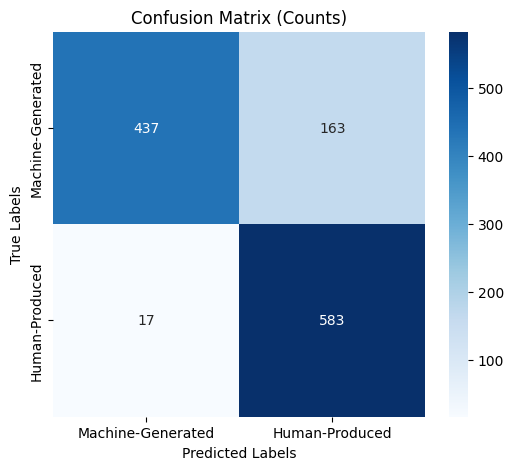

In [70]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting confusion matrix with counts
# Calculate the confusion matrix without normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plotting confusion matrix with percentages
# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')


In [71]:
import numpy as np
# Extracting TP, TN, FP, FN
TP = cm[0, 0]  # True Positive: correct machine-generated predictions
FN = cm[0, 1]  # False Negative: machine-generated incorrectly predicted as human-produced
FP = cm[1, 0]  # False Positive: human-produced incorrectly predicted as machine-generated
TN = cm[1, 1]  # True Negative: correct human-produced predictions

# Calculate Accuracy, Precision, and Recall
accuracy = (TP + TN) / np.sum(cm)  # sum of the matrix elements is the total number of samples
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Accuracy: 0.8500
Precision: 0.9626
Recall: 0.7283
